# Netflow data
The data was taken from: [Machine Learning-Based NIDS Datasets](https://staff.itee.uq.edu.au/marius/NIDS_datasets/)

**Note: you will need to unzip the file cyberdata_mlai/data/netflow/7ca78ae35fa4961a_MOHANAD_A4706.zip** before you run this notebook.

In [1]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipaddress

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline

from matplotlib import pyplot
from summarytools import dfSummary
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Data processing

In [2]:
data = pd.read_csv("./data/netflow/7ca78ae35fa4961a_MOHANAD_A4706/data/NF-ToN-IoT.csv")

In [3]:
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.1.195,63318,52.139.250.253,443,6,91.00,181,165,2,1,24,327,0,Benign
1,192.168.1.79,57442,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
2,192.168.1.79,57452,239.255.255.250,15600,17,0.00,63,0,1,0,0,0,0,Benign
3,192.168.1.193,138,192.168.1.255,138,17,10.16,472,0,2,0,0,0,0,Benign
4,192.168.1.79,51989,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign


In [4]:
data.dtypes

IPV4_SRC_ADDR                  object
L4_SRC_PORT                     int64
IPV4_DST_ADDR                  object
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
Label                           int64
Attack                         object
dtype: object

## Check for duplicates

In [5]:
duplicates = data[data.duplicated()]

print(f"Number of duplicate rows: {len(duplicates)}")
if not duplicates.empty:
    print("Duplicate rows: ")
    print(duplicates)

Number of duplicate rows: 168345
Duplicate rows: 
         IPV4_SRC_ADDR  L4_SRC_PORT    IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
246        192.168.1.1            0        224.0.0.1            0         2   
247      192.168.1.169            0      224.0.0.251            0         2   
250       192.168.1.79            0  239.255.255.250            0         2   
1302       192.168.1.1            0        224.0.0.1            0         2   
1305     192.168.1.169            0      224.0.0.252            0         2   
...                ...          ...              ...          ...       ...   
1379101   192.168.1.30        33143      192.168.1.1           53        17   
1379153   192.168.1.31        48314      192.168.1.1           53        17   
1379154   192.168.1.31        48314      192.168.1.1           53        17   
1379260   192.168.1.30        52999      192.168.1.1           53        17   
1379261   192.168.1.30        52999      192.168.1.1           53        17   

 

In [6]:
data.size

19309836

In [7]:
data = data.drop_duplicates()

In [8]:
data.size

16953006

## Check for missing values
This dataset does not have missing values.

In [9]:
data.isnull().sum()

IPV4_SRC_ADDR                 0
L4_SRC_PORT                   0
IPV4_DST_ADDR                 0
L4_DST_PORT                   0
PROTOCOL                      0
L7_PROTO                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
TCP_FLAGS                     0
FLOW_DURATION_MILLISECONDS    0
Label                         0
Attack                        0
dtype: int64

## Generate numerical features
Netflow conveniently includes numerical features. We only need to convert IPs and types of attacks:
- **IPs**: use `ipaddress` that performs conversion of the IP and can give additional information that can be codified, such as `is_private` IP.
- **Attack**: this is a label that can be used for multi-class classification. We perform a two-class classification in this notebook, using `Label`. We modify the `Attack` to a numeric mapping for future use.

In [10]:
def convert_ip(ip):
    try:
        ip_num = int(ipaddress.ip_address(ip))
        is_private = ipaddress.ip_address(ip).is_private
        return ip_num, is_private
    except ValueError:
        return None, None

In [11]:
data["IPV4_SRC_ADDR_NUMERIC"], data["IPV4_SRC_ADDR_PRIVATE"] = zip(
    *data["IPV4_SRC_ADDR"].apply(convert_ip)
)
data["IPV4_DST_ADDR_NUMERIC"], data["IPV4_DST_ADDR_PRIVATE"] = zip(
    *data["IPV4_DST_ADDR"].apply(convert_ip)
)

In [12]:
data.pop("IPV4_SRC_ADDR")
data.pop("IPV4_DST_ADDR")

0           52.139.250.253
1            192.168.1.255
2          239.255.255.250
3            192.168.1.255
4            192.168.1.255
                ...       
1379269      192.168.1.194
1379270      192.168.1.194
1379271      192.168.1.194
1379272      192.168.1.194
1379273      192.168.1.194
Name: IPV4_DST_ADDR, Length: 1210929, dtype: object

In [13]:
attack_list = data["Attack"].unique().tolist()
attack_list

['Benign',
 'dos',
 'injection',
 'ddos',
 'scanning',
 'password',
 'mitm',
 'xss',
 'backdoor',
 'ransomware']

In [14]:
attack_mapping = {
    "Benign": 0,
    "dos": 1,
    "injection": 2,
    "ddos": 3,
    "scanning": 4,
    "password": 5,
    "mitm": 6,
    "xss": 7,
    "backdoor": 8,
    "ransomware": 9,
}
data["Attack"] = data["Attack"].map(attack_mapping)

In [15]:
data.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,IPV4_SRC_ADDR_NUMERIC,IPV4_SRC_ADDR_PRIVATE,IPV4_DST_ADDR_NUMERIC,IPV4_DST_ADDR_PRIVATE
0,63318,443,6,91.00,181,165,2,1,24,327,0,0,3232235971,True,881588989,False
1,57442,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,True,3232236031,True
2,57452,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,True,4026531834,False
3,138,138,17,10.16,472,0,2,0,0,0,0,0,3232235969,True,3232236031,True
4,51989,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,True,3232236031,True


In [16]:
data["IPV4_SRC_ADDR_PRIVATE"] = data["IPV4_SRC_ADDR_PRIVATE"].map({False: 0, True: 1})
data["IPV4_DST_ADDR_PRIVATE"] = data["IPV4_DST_ADDR_PRIVATE"].map({False: 0, True: 1})

In [17]:
data.dtypes

L4_SRC_PORT                     int64
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
Label                           int64
Attack                          int64
IPV4_SRC_ADDR_NUMERIC           int64
IPV4_SRC_ADDR_PRIVATE           int64
IPV4_DST_ADDR_NUMERIC           int64
IPV4_DST_ADDR_PRIVATE           int64
dtype: object

## Check for outliers

In [18]:
# get column names 
num_cols = data.columns

In [19]:
def flag_outliers(df, column):
    df_copy = df.copy()  # Create a copy of the original DataFrame
    Q1 = df_copy[column].quantile(0.25)
    Q3 = df_copy[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy[f"{column}_is_outlier"] = (
        (df_copy[column] < lower_bound) | (df_copy[column] > upper_bound)
    ).astype(int)
    return df_copy  # Return the modified copy


for col in num_cols:
    data_outliers = flag_outliers(
        data, col
    )  # Update to use the returned DataFrame

In [20]:
data_outliers

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,IPV4_SRC_ADDR_NUMERIC,IPV4_SRC_ADDR_PRIVATE,IPV4_DST_ADDR_NUMERIC,IPV4_DST_ADDR_PRIVATE,IPV4_DST_ADDR_PRIVATE_is_outlier
0,63318,443,6,91.00,181,165,2,1,24,327,0,0,3232235971,1,881588989,0,1
1,57442,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,1,3232236031,1,0
2,57452,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,1,4026531834,0,1
3,138,138,17,10.16,472,0,2,0,0,0,0,0,3232235969,1,3232236031,1,0
4,51989,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,1,3232236031,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,58032,80,6,7.00,216,180,4,3,18,9433,1,3,3232235807,1,3232235970,1,0
1379270,58034,80,6,7.00,216,180,4,3,18,9221,1,3,3232235807,1,3232235970,1,0
1379271,58036,80,6,7.00,216,180,4,3,18,9656,1,3,3232235807,1,3232235970,1,0
1379272,58038,80,6,7.00,216,180,4,3,18,10046,1,3,3232235807,1,3232235970,1,0


In [21]:
data

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,IPV4_SRC_ADDR_NUMERIC,IPV4_SRC_ADDR_PRIVATE,IPV4_DST_ADDR_NUMERIC,IPV4_DST_ADDR_PRIVATE
0,63318,443,6,91.00,181,165,2,1,24,327,0,0,3232235971,1,881588989,0
1,57442,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,1,3232236031,1
2,57452,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,1,4026531834,0
3,138,138,17,10.16,472,0,2,0,0,0,0,0,3232235969,1,3232236031,1
4,51989,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,1,3232236031,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,58032,80,6,7.00,216,180,4,3,18,9433,1,3,3232235807,1,3232235970,1
1379270,58034,80,6,7.00,216,180,4,3,18,9221,1,3,3232235807,1,3232235970,1
1379271,58036,80,6,7.00,216,180,4,3,18,9656,1,3,3232235807,1,3232235970,1
1379272,58038,80,6,7.00,216,180,4,3,18,10046,1,3,3232235807,1,3232235970,1


## Explore
Quick exploration using dfSummary. Some conclusions:
- The data is unbalanced, since ~82% is malicious
- in/out packets and in/out bytes have a large concentration on small values. Maybe a long tail on larger values can be useful for detection.
- flow duration may also be a feature with long tail distribution that gives information. 

In [22]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,L4_SRC_PORT[int64],Mean (sd) : 42441.4 (16717.3)min < med < max:0.0 < 46166.0 < 65535.0IQR (CV) : 16706.0 (2.5),"38,857 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACiklEQVR4nO3dvY7aQBRA4Tv8yQvEFkKBjmbLlVK45CHysGnTpeAJKNKkokFICIxw1sLYTpFE2mrBM/biC+frB0boCPbKmllTFIUATde69QaAa3RuvQE0hzHmSUR6Di9xKoritar9vEWoEJG/kY7H46++749sX+NwOOyMMd/qiJVQ8V/P9/3RfD5/DYIgKbs4iiJvsViMttttT0QIFfUKgiCZTCa/LZc/VbqZNximoAKhQgV++u+Mw+Tu53nerXo/VSHUO+Iyuadp6mVZ9pIkyQ8Rsf0btTaEel+sJ/fVajVaLpf98/ncrmtzLgj1DtlM7rvdrraJvQoMU1CBb9QaOD6KbIlIbrm20QORC0KtmMtAk2VZN47j5+Fw+KvVaqVl1zd9IHJBqNVzHWg+h2H4czqd7sq+cdMHIheEWhOXgWYwGFg9xmz6QOSCYQoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFDh4uE+xzPqtV2Vjcfybqiu12XXeVU2Hsulb1TrM+p1X5WNx3LVuX6H67Lv9pw5PhbDFFQgVKhAqFCBUKECoUIFbvNDZbIs64qIb4yxWf7uwyFCRSXiOO6mafplNpu12+126X9ReenhEKGiEqfTqeN5Xj8Mw6TsJcTXPBwiVFTK9hJiufBwiGEKKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUqPUoiuOpRBGurcQ/V4UaRZFX9oXX6/Unl1OJIiL7/f5ojPkuIlbrb8TP87xj85kdj0dPRCSOY2+z2fQ/cv0t3/uaz+oPEQr8/VNf3QMAAAAASUVORK5CYII="">",0(0.0%)
2,L4_DST_PORT[int64],Mean (sd) : 6211.3 (15726.4)min < med < max:0.0 < 80.0 < 65534.0IQR (CV) : 363.0 (0.4),"16,071 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACHklEQVR4nO3XsW7aYBSG4XMgILuybCM3jF46eOMCWHoHudis3dlzAQzZgdhWXGio625dqpbYLkk/6X1mzvkN/ysQ3nWdAf+7yXs/APAaN5de4O6hmc0H7n/puu44cBb45a+hunuYZdldHMeLIcvrun5y93tixViXvlHncRwv1uv1MUmSU5/FVVUFm81msd/v52ZGqBjl4k+/mVmSJKflcvl1wP5wwAzwG/5MQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQsLNNZe3bTszs9jdh6546bru+A8f6U24e2hm84HjEzP7MeL4MfNjz77afV0t1KZpZufzeZXn+XQ6nZ6G7CjL8tndv5jZkPl3idzdwyzL7uI4XvSdbdt21jTNpyiKtpPJ5PyW82PPNrvufb0q1Kqqgr6nHg6HKAiCD0VReJqm3/rOl2UZPTw8fM7z/OOQ0Ed+aGPEURTdrlar72EY9nrfu90u2G63t0VRPKZp+tz34DHzY88ee191XT+5+/2fYv0JJi2jS2bpOd0AAAAASUVORK5CYII="">",0(0.0%)
3,PROTOCOL[int64],1. 62. 173. 24. 15. 58,"1,095,432 (90.5%)114,253 (9.4%)878 (0.1%)312 (0.0%)54 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACHElEQVR4nO3bwY3TUBiF0f9F0cBsbEWRUgL0kCIoliJcBD1EUbxghtmYBQ0Qe+Ya4nP2lt7iU54c+bZpmgoSdmsfgO0QGzFiI6ZV1XNVPa19EP4bb9M0vcx5cH88Hr91XXd47xPxmMZxvLbWvs8Jbt913eF8Pr/0ff/6EYfjcdxut8/DMBwul8tTVd0fW1VV3/evp9Pp57ufjkf0PPdBLwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsy+6s+nI2sfhH/f0k724zheh2E41IJPR9iOcRyvVfU251mfhXOv2Z+FN7tRUrwgELP0Gp39k8r2LFpXLVnasD2z11VLlzZsz9J1lb9L+GteEIgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmNnrKoss7rVoXbVkacP2+CycGOsqYrwgECM2Ynatta+tNW+WfLhdVX2pqk9rH4TH5xolRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiNlV1Y+q+rX2QXh8Bi/EuEaJERsxBi/EGLwQ4xolRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMdZVxFhXEeMaJUZsxFhXEWNdRYxrlBixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMRYVxFjXUWMa5QYsREjNmJ+A8prffgD5Hx3AAAAAElFTkSuQmCC"">",0(0.0%)
4,L7_PROTO[float64],Mean (sd) : 25.2 (36.6)min < med < max:0.0 < 7.0 < 251.0IQR (CV) : 0.2 (0.7),97 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACCUlEQVR4nO3aQYrbQBBG4SrjCAtMN7JAF8gttM92Djvb7HWLHEGMW8RjZ4Lc2WUTEo+kCfYv3rd2l2vxkBFuzzkb8Og2914AeI/trQ+4e2lmxcz5bznn88yzwG//DNXdy7qun0II1ZzhwzC8uPszsWKpW0/UIoRQtW17jjFepgxOKe26rqv6vi/MjFCxyM2

# Feature engineering

In [23]:
features = data.drop(["Label", "Attack"], axis=1)
features

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC_ADDR_NUMERIC,IPV4_SRC_ADDR_PRIVATE,IPV4_DST_ADDR_NUMERIC,IPV4_DST_ADDR_PRIVATE
0,63318,443,6,91.00,181,165,2,1,24,327,3232235971,1,881588989,0
1,57442,15600,17,0.00,63,0,1,0,0,0,3232235855,1,3232236031,1
2,57452,15600,17,0.00,63,0,1,0,0,0,3232235855,1,4026531834,0
3,138,138,17,10.16,472,0,2,0,0,0,3232235969,1,3232236031,1
4,51989,15600,17,0.00,63,0,1,0,0,0,3232235855,1,3232236031,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,58032,80,6,7.00,216,180,4,3,18,9433,3232235807,1,3232235970,1
1379270,58034,80,6,7.00,216,180,4,3,18,9221,3232235807,1,3232235970,1
1379271,58036,80,6,7.00,216,180,4,3,18,9656,3232235807,1,3232235970,1
1379272,58038,80,6,7.00,216,180,4,3,18,10046,3232235807,1,3232235970,1


In [24]:
target = data["Label"]

## Feature correlation with target
In this notebook, we are building a classifier for attacks vs benign netflow data. Therefore, our target is the `Label` column that marks an attack with a 1 and benign traffic with 0. 

It is important to find features that may bias our classification. The first step is to check features that have high correlation with the target, i.e., the `Label`. 

In [25]:
# Concatenate the features and target into a single DataFrame for correlation calculation
data = pd.concat([features, target], axis=1)

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Extract correlations of each feature with the target
target_corr = correlation_matrix["Label"].drop(
    "Label"
)  # Drop target's correlation with itself

# Filter features with high correlation with the target, e.g., above 0.8 or below -0.8
high_corr_features = target_corr[abs(target_corr) > 0.5]

print("Highly correlated features with the target:")
print(high_corr_features)

Highly correlated features with the target:
L4_SRC_PORT    0.625169
L4_DST_PORT   -0.826127
Name: Label, dtype: float64


## Correlated features
Some features may be correlated with each other. This means that they may have overlapping information. Therefore, we can use only of the two features.

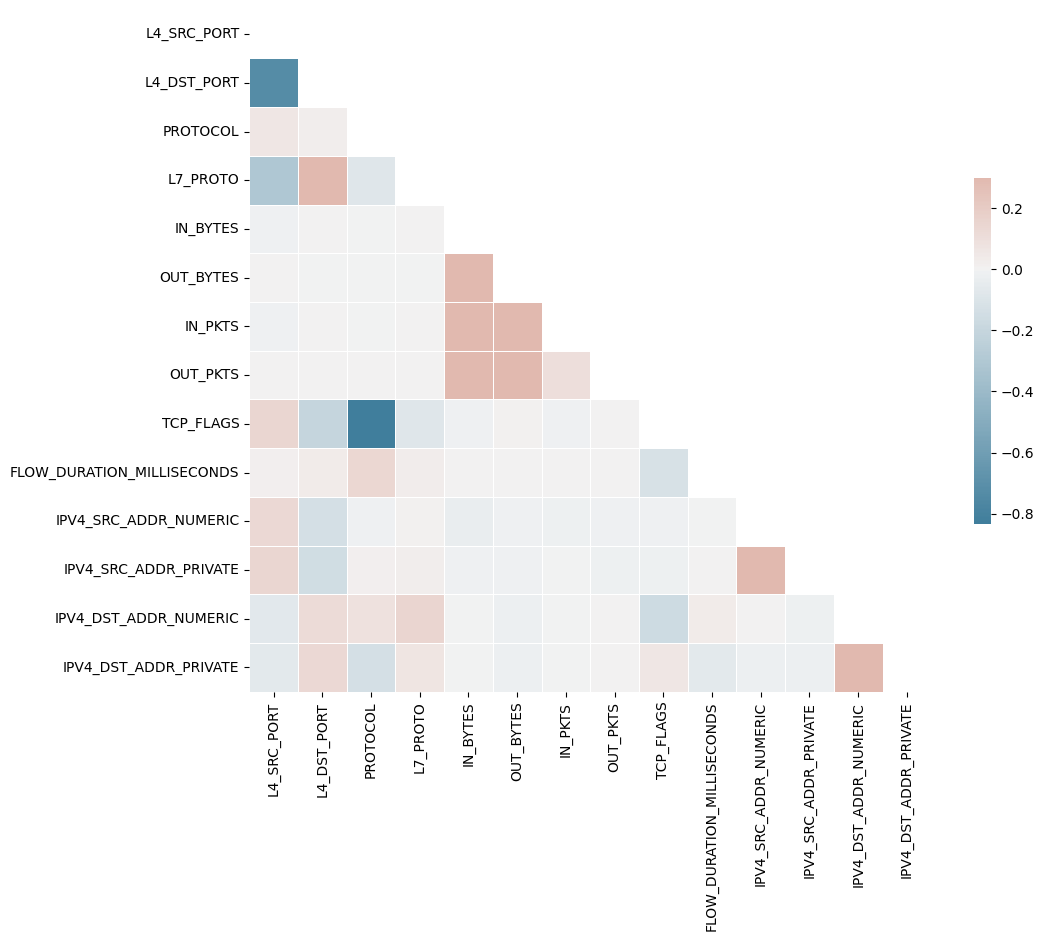

In [26]:
# Calculate the correlation matrix
corr_matrix = features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

plt.show()

# Feature selection

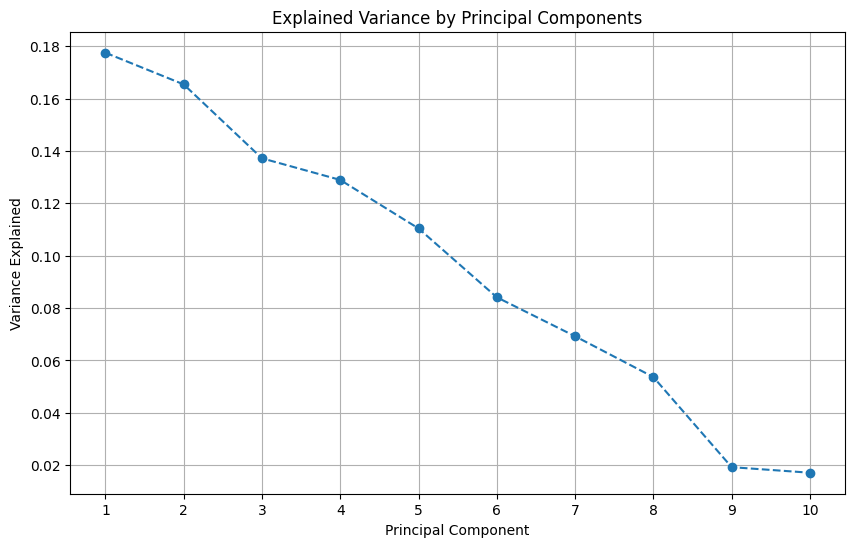

Principal Components and their corresponding features:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  OUT_BYTES  \
0    -0.049073     0.049779  0.003264  0.024758  0.551461   0.521728   
1    -0.463389     0.498479  0.127113  0.289533 -0.049519  -0.070578   
2    -0.037162    -0.018952 -0.562008 -0.033174 -0.026070  -0.019213   
3    -0.052447     0.058175 -0.340033  0.190191  0.031714   0.019858   
4     0.418715    -0.367734  0.201265 -0.320673  0.010011  -0.009470   
5     0.001938     0.011977  0.009749 -0.000793 -0.367564   0.389814   
6     0.078016    -0.035544 -0.134455  0.152838 -0.003815  -0.000762   
7     0.339680    -0.289666  0.035253  0.857670 -0.004126   0.001379   
8     0.664426     0.696380  0.072979 -0.001523 -0.022739   0.052534   
9    -0.057176    -0.051429  0.017418  0.002596 -0.375501   0.726380   

    IN_PKTS  OUT_PKTS  TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
0  0.488972  0.409911  -0.014601                    0.007625   
1 -0.047715 -0.045619  -

In [27]:
# Assuming 'data' is your DataFrame and 'target' is your target variable
# Separate features and target
X = data.drop(columns=["Label"])  # Replace 'Label' with your target column name
y = data["Label"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Get the components and their corresponding feature names
components = pd.DataFrame(pca.components_, columns=X.columns)

# Display the most important features for each principal component
print("Principal Components and their corresponding features:")
print(components)

# To select the most important features based on the first principal component
important_features = components.iloc[0].abs().nlargest(5)  
print("Top 5 important features based on the first principal component:")
print(important_features)

# Classification

In [28]:
# use the PCA selected features
X_df = data[["IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS", "IPV4_SRC_ADDR_NUMERIC"]]

In [29]:
y = np.array(data["Label"])
X = np.array(X_df)

In [30]:
# shuffle the data to make sure that attacks and benign are mixed well
indices = list(range(len(y)))
random.shuffle(indices)
X, y = X[indices], y[indices]
label_counts = np.bincount(y)
print("Labels equal to 1:", label_counts[1])
print("Labels equal to 0:", label_counts[0])

Labels equal to 1: 998118
Labels equal to 0: 212811


## To scale or not to scale

Scaling adjusts the range of our features. It is important in gradient or distance calculating models because it ensures fair contribution of each feature to the model.

Scaling pros:
- decreases biasing of outliers in classification
- improves model accuracy
- better convergence for gradient models

Scaling cons:
- overfitting
- scale invariant models: some models are not necessarily benefiting from scaling, ex. ensemble models
- bad interpretability since we change original units of features

**Standard scaler**
- mean of 0, std 4
- good for normally distributed data
**Normalized scaler**
- fit data within a range, usually [0, 1]
- good for data with varying ranges but not specific distribution
**Robust scaler**
- adjusts based on Interquartile Range (IQR), i.e., range between 25th and 75th percentile
- resilient to outliers
- formula: `x_scaled = (x - meadian_x) / IQR`


In [31]:
# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42
# )

# # Models without scaling
# model_rf = RandomForestClassifier(random_state=42)
# model_svc = SVC(random_state=42)

# # Models with scaling
# model_rf_scaled = make_pipeline(RobustScaler(), RandomForestClassifier(random_state=42))
# model_svc_scaled = make_pipeline(RobustScaler(), SVC(random_state=42))

# # Cross-Validation Comparison
# cv_scores_rf = cross_val_score(model_rf, X_train, y_train, cv=3)
# cv_scores_rf_scaled = cross_val_score(model_rf_scaled, X_train, y_train, cv=3)
# cv_scores_svc = cross_val_score(model_svc, X_train, y_train, cv=3)
# cv_scores_svc_scaled = cross_val_score(model_svc_scaled, X_train, y_train, cv=3)

# # Print Results
# print("Random Forest without scaling:", np.mean(cv_scores_rf))
# print("Random Forest with scaling:", np.mean(cv_scores_rf_scaled))
# print("SVC without scaling:", np.mean(cv_scores_svc))
# print("SVC with scaling:", np.mean(cv_scores_svc_scaled))

## Split matters
Split strategies:
- k-fold: use this when the data is balanced
- stratified: use this when data distribution needs to be similar in different folds because the data is unbalanced.

In [32]:
# # Using StratifiedKFold with a RobustScaler pipeline
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# model = make_pipeline(RobustScaler(), RandomForestClassifier(random_state=42))

# # Cross-validation with StratifiedKFold
# stratified_scores = cross_val_score(model, X, y, cv=stratified_kfold)
# print("StratifiedKFold scores:", stratified_scores, "Mean:", np.mean(stratified_scores))

# # Cross-validation with KFold
# kfold_scores = cross_val_score(model, X, y, cv=kfold)
# print("KFold scores:", kfold_scores, "Mean:", np.mean(kfold_scores))

# # Train-test split (for quick comparison)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42
# )
# model.fit(X_train, y_train)
# train_test_score = model.score(X_test, y_test)
# print("Train-test split score:", train_test_score)

### Simple 80-20 split

In [33]:
# scaler = RobustScaler()
# X_df_scaled = scaler.fit_transform(X_df)
# X = np.array(X_df_scaled)

In [34]:
splitpoint = int(len(X) * 0.8)
X_train, X_test = X[:splitpoint], X[splitpoint:]
y_train, y_test = y[:splitpoint], y[splitpoint:]

In [35]:
classifier = XGBClassifier(
    booster="gbtree", tree_method="hist", max_depth=3, min_child_weight=1, subsample=0.8
)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
# get the prediction probabilities for all samples (:) and the column that indicates malicious (-1) flows
scores = classifier.predict_proba(X_test)[:,1]

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

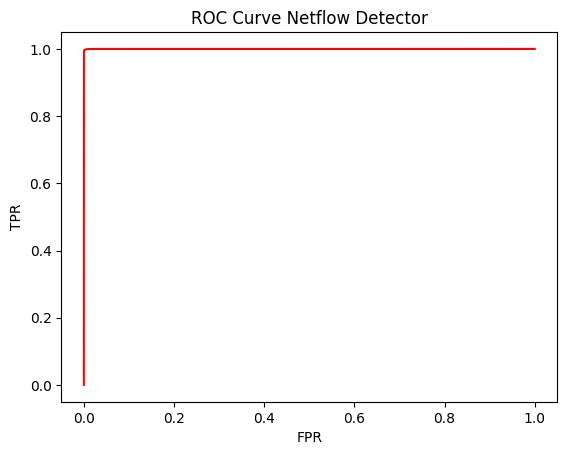

In [38]:
pyplot.plot(fpr, tpr, 'r-')
pyplot.xlabel("FPR")
pyplot.ylabel("TPR")
pyplot.title("ROC Curve Netflow Detector")
pyplot.show()

### K-Fold split

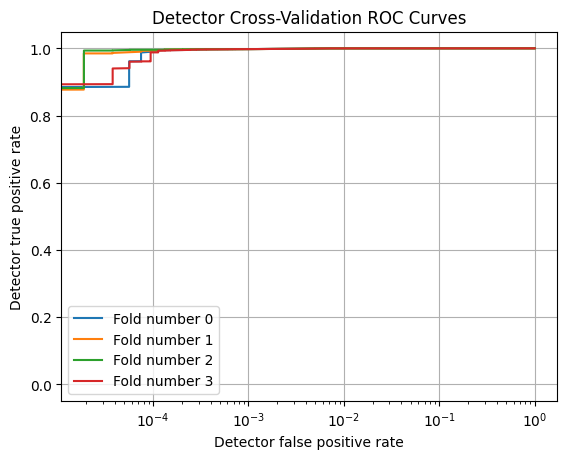

In [39]:
fold_counter = 0

kf = KFold(n_splits=4, shuffle=True)
classifier = RandomForestClassifier(max_depth=20, min_samples_split=20, max_features=4, n_estimators=100, min_samples_leaf=10, bootstrap=True)

for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    classifier.fit(X_train, y_train)
    
    scores = classifier.predict_proba(X_test)[:,-1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
    
    pyplot.semilogx(fpr, tpr, label=f"Fold number {fold_counter}")
    fold_counter += 1
    
pyplot.xlabel("Detector false positive rate")
pyplot.ylabel("Detector true positive rate")
pyplot.title("Detector Cross-Validation ROC Curves")
pyplot.legend()
pyplot.grid()
pyplot.show()

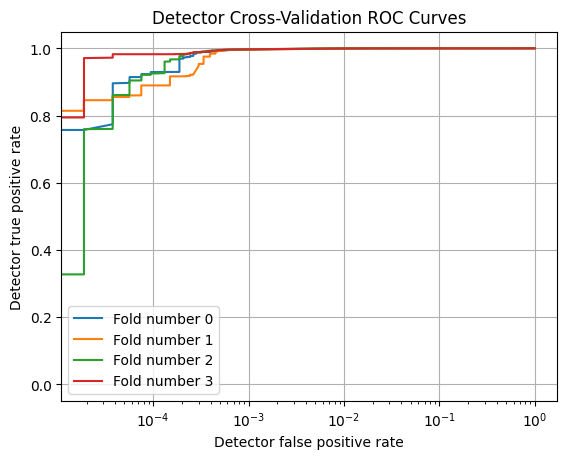

In [40]:
fold_counter = 0

kf = KFold(n_splits=4, shuffle=True)
classifier = XGBClassifier(
    booster="gbtree", tree_method="hist", max_depth=3, min_child_weight=1, subsample=0.8
)

for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    classifier.fit(X_train, y_train)
    
    scores = classifier.predict_proba(X_test)[:,-1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
    
    pyplot.semilogx(fpr, tpr, label=f"Fold number {fold_counter}")
    fold_counter += 1

pyplot.xlabel("Detector false positive rate")
pyplot.ylabel("Detector true positive rate")
pyplot.title("Detector Cross-Validation ROC Curves")
pyplot.legend()
pyplot.grid()
pyplot.show()

### Stratified

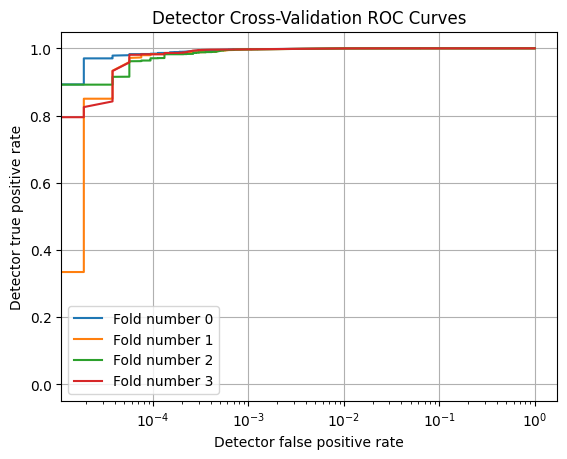

In [41]:
fold_counter = 0

# Initialize stratified k-fold with 4 splits
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Initialize model
model = XGBClassifier(
    booster="gbtree", tree_method="hist", max_depth=3, min_child_weight=1, subsample=0.8
)

# To store results
auc_scores = []

# Loop through each fold
for train_index, test_index in skf.split(X, y):
    # Split into train and test for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Use SMOTE only on the training data to prevent leakage
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Fit the model on resampled data
    model.fit(X_resampled, y_resampled)

    # Predict on the test set
    y_pred = model.predict_proba(X_test)[:, 1]

    scores = classifier.predict_proba(X_test)[:,-1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

    pyplot.semilogx(fpr, tpr, label=f"Fold number {fold_counter}")
    fold_counter += 1

pyplot.xlabel("Detector false positive rate")
pyplot.ylabel("Detector true positive rate")
pyplot.title("Detector Cross-Validation ROC Curves")
pyplot.legend()
pyplot.grid()
pyplot.show()

In [42]:
#    import seaborn as sns
#    import matplotlib.pyplot as plt

#    # Example: Visualizing a feature in training vs. test set
#    sns.histplot(train_data['feature_name'], color='blue', label='Train', kde=True)
#    sns.histplot(test_data['feature_name'], color='red', label='Test', kde=True)
#    plt.legend()
#    plt.title('Feature Distribution: Train vs. Test')
#    plt.show()